In [1]:
import pyarrow.parquet as pq
import pandas as pd
import os

# column rename dictionaries
yellow_col_dict = {"tpep_pickup_datetime": "Pickup_datetime",
                   "tpep_dropoff_datetime": "Dropoff_datetime",
                   }

green_col_dict = {"lpep_pickup_datetime": "Pickup_datetime",
                   "lpep_dropoff_datetime": "Dropoff_datetime",
                   }

fhv_col_dict = {"pickup_datetime": "Pickup_datetime",
                "dropOff_datetime": "Dropoff_datetime",
                "PUlocationID": "PULocationID",
                "DOlocationID": "DOLocationID",
                }

# key_columns
yellow_or_green_columns = ["Vehicle_type",
                        "Pickup_datetime",
                        "Dropoff_datetime",
                        "passenger_count",
                        "trip_distance",
                        "PULocationID",
                        "DOLocationID",
                        "RatecodeID",
                        "payment_type",
                        "fare_amount",
                        "extra",
                        "total_amount",
                        "congestion_surcharge"]

fhv_columns = ["Vehicle_type",
            "Pickup_datetime",
            "Dropoff_datetime",
            "PULocationID",
            "DOLocationID",
            "SR_Flag"]

In [2]:
def get_dataframe_from_parquet_file(file_name: str) -> pd.DataFrame:
    """Takes a parquet file name, returns a dataframe.
    
    Takes: str
    
    Returns: pd.DataFrame
    """

    data = pq.read_table(f'../data/trip/{file_name}')
    df: pd.DataFrame = data.to_pandas()

    print(df.columns)
    
    if "yellow" in file_name:
        # case 1: Yellow Taxi
        df["Vehicle_type"] = "Yellow"
        df.rename(columns=yellow_col_dict, inplace=True)
        df = df[yellow_or_green_columns]

    elif "green" in file_name:
        # case 2: Green Taxi
        df["Vehicle_type"] = "Green"
        df.rename(columns=green_col_dict, inplace=True)
        df = df[yellow_or_green_columns]

    else:
        # case 3: For Hire Vehicle
        df["Vehicle_type"] = "FHV"
        df.rename(columns=fhv_col_dict, inplace=True)
        df = df[fhv_columns]

    return df

def get_all_trip_data_in_data_directory(year_month: str) -> pd.DataFrame:
    """Returns trip data of a particular year/month in the as a single dataframe.
    
    Takes: str
    
    Returns: pd.DataFrame
    """
    
    final_df = pd.DataFrame()

    for file in os.listdir("../data/trip"):
        if year_month in file:
            print(file)
            df = get_dataframe_from_parquet_file(file)

            final_df = pd.concat([final_df, df])

    return final_df

dec_df = get_all_trip_data_in_data_directory(year_month="2023-12")

print(dec_df.head())
dec_df.head().to_csv("head.csv")

yellow_tripdata_2023-12.parquet
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')
fhv_tripdata_2023-12.parquet
Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')
green_tripdata_2023-12.parquet
Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'conges

In [3]:
# Part 1: Feature Engineering

# calculate trip duration in minutes based on pickup and dropoff timestamps
dec_df["Pickup_datetime"] = pd.to_datetime(dec_df["Pickup_datetime"])
dec_df["Dropoff_datetime"] = pd.to_datetime(dec_df["Dropoff_datetime"])

# drop rows with null values in pickup or dropoff datetime column
dec_df.dropna(how="any", subset=["Pickup_datetime", "Dropoff_datetime"], inplace=True)

dec_df["trip_duration_in_mins"] = round((dec_df["Dropoff_datetime"] - dec_df["Pickup_datetime"]) / pd.Timedelta(minutes=1), 2)

# check result
dec_df[["Pickup_datetime", "Dropoff_datetime", "trip_duration_in_mins"]].head().to_csv("duration.csv")

# Datetime Parsing
# (1) extract pickup day of week (Mon, Tue, etc)
dec_df["PU_day_of_week"] = dec_df["Pickup_datetime"].dt.strftime('%a')

# (2) extract time of the day & categorize to morning/afternoon/evening
# helper
def categorize_time_of_day(hour: int) -> str:
    """Takes an int representing hour of the time, returns time of the day.
    
    Takes:
        int: the hour of the time

    Returns:
        str: one of "morning", "afternoon", "evening", "night" """
    
    MORNING = range(6, 12)
    AFTERNOON = range(12, 18)
    EVENING = range(18, 24)
    NIGHT = range(0, 6)
    
    if hour in MORNING:
        return "Morning"
    elif hour in AFTERNOON:
        return "Afternoon"
    elif hour in EVENING:
        return "Evening"
    elif hour in NIGHT:
        return "Night"
    
    return ValueError("Input hour parameter is not within the expected 0 - 24 range.")

dec_df["PU_hour"] = dec_df["Pickup_datetime"].dt.hour
dec_df["Time_of_the_day"] = dec_df["PU_hour"].apply(categorize_time_of_day)

# (3) extract day of the datetime (for merging with external weather data later)
dec_df["PU_day"] = dec_df["Pickup_datetime"].dt.day

# Data Cleaning

# filter out erroneous entries such as negative total fare amount and zero duration trips
filtered_df = dec_df[(dec_df["total_amount"] >= 0) & (dec_df["trip_duration_in_mins"] > 0)]

filtered_df.head(100).to_csv("filtered.csv")

# Data Cleaning and Filtering - DONE
# Clean and filter the data to remove outliers, erroneous entries, or incomplete records. This may involve removing trips with unrealistic values (e.g., negative fares, zero duration),
# correcting data inconsistencies, and handling missing or invalid values.

# Date and Time Parsing: - DONE
# Extract meaningful date and time components from the timestamp data, such as year, month, day of the week, hour of the day, and time of day (e.g., morning, afternoon, evening).
# This can help analyze temporal patterns in taxi usage.

In [7]:

# Part 3: Data Processing & Aggregate Statistics

# TODO Aggregate Statistics:
# Calculate summary statistics for various aspects of taxi trips, such as total number of trips,
# average fare amount, average trip duration, and total distance traveled.
# Aggregate the data at different levels of granularity (e.g., hourly, daily, weekly) to analyze trends over time.

# TODO AGG 1 - by day of the week

final_df = filtered_df.copy()
final_df["Index"] = final_df.index

# Index, Vehicle_type, trip_distance, total_amount, trip_duration_in_mins

day_of_week_df = final_df[["Index", "Vehicle_type", "trip_distance", "total_amount", "trip_duration_in_mins", "PU_day_of_week"]].groupby(by=["Vehicle_type", "PU_day_of_week"]).agg({"Index":"count", "trip_distance": "mean", "total_amount": "mean", "trip_duration_in_mins":"mean"})
day_of_week_df.rename(columns={"Index": "Count"}, inplace=True)

# TODO AGG 2 - by the time of the day
time_of_the_day_df = final_df[["Index", "Vehicle_type", "trip_distance", "total_amount", "trip_duration_in_mins", "Time_of_the_day"]].groupby(by=["Vehicle_type", "Time_of_the_day"]).agg({"Index":"count", "trip_distance": "mean", "total_amount": "mean", "trip_duration_in_mins":"mean"})
time_of_the_day_df.rename(columns={"Index": "Count"}, inplace=True)

print(day_of_week_df.head(5))
print(time_of_the_day_df.head(5))

# TODO Customer Segmentation:
# Segment taxi trips based on customer characteristics such as trip purpose
# (e.g., airport transfers, commuting, leisure), passenger count, and payment method.
# This can help understand customer preferences and behavior.

# TODO Time Series Analysis:
# Apply time series analysis techniques to analyze temporal trends in taxi usage,
# such as daily and weekly patterns, seasonality, and long-term trends.
# This can help forecast future demand and optimize taxi fleet management.


# TODO get Dec 2023 NYC Westher data
# TODO Join with External Datasets:
# Enrich the taxi trip data by joining it with external datasets, such as weather data,
# demographic data, event calendars, and public transportation schedules.
# This can provide additional context and insights into factors influencing taxi usage.

                             Count  trip_distance  total_amount  \
Vehicle_type PU_day_of_week                                       
Green        Fri             11700      13.882573     24.823272   
             Mon              7712      22.772452     24.213301   
             Sat              9405      19.754255     24.526149   
             Sun              7692      31.206011     23.409826   
             Thu              9316      36.871861     24.562172   

                             trip_duration_in_mins  
Vehicle_type PU_day_of_week                         
Green        Fri                         21.508985  
             Mon                         17.977980  
             Sat                         21.537163  
             Sun                         20.028696  
             Thu                         20.855848  
                                Count  trip_distance  total_amount  \
Vehicle_type Time_of_the_day                                         
Green        Aftern

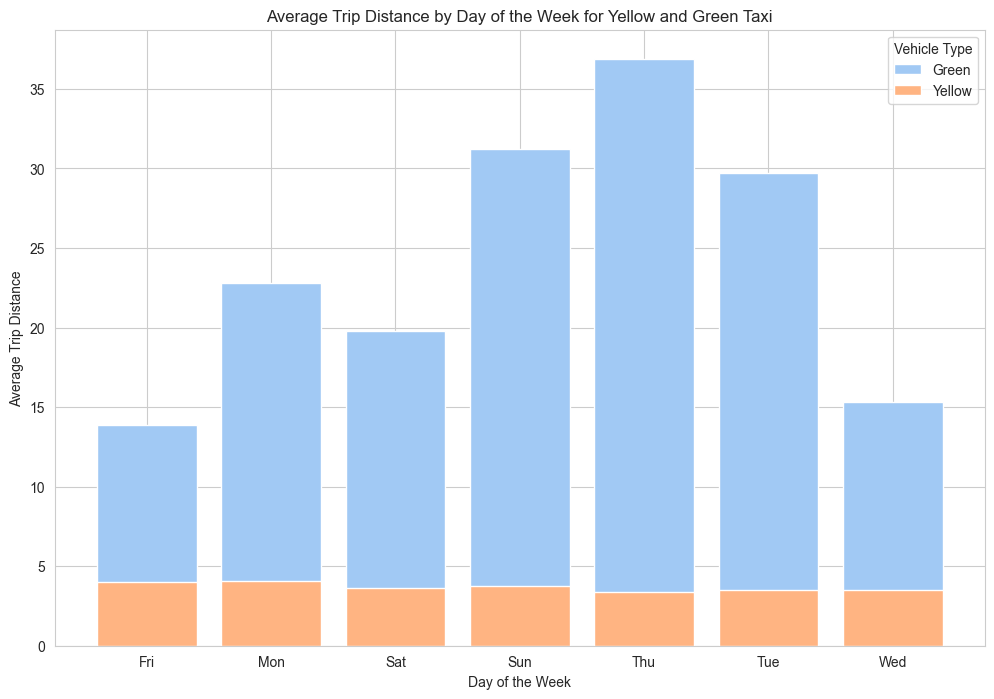

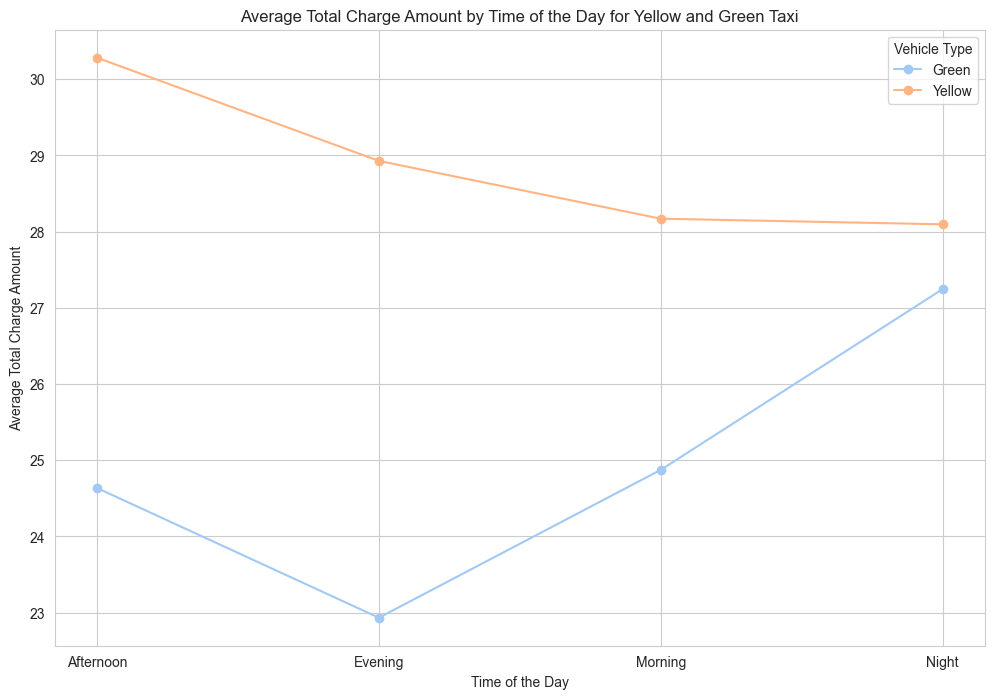

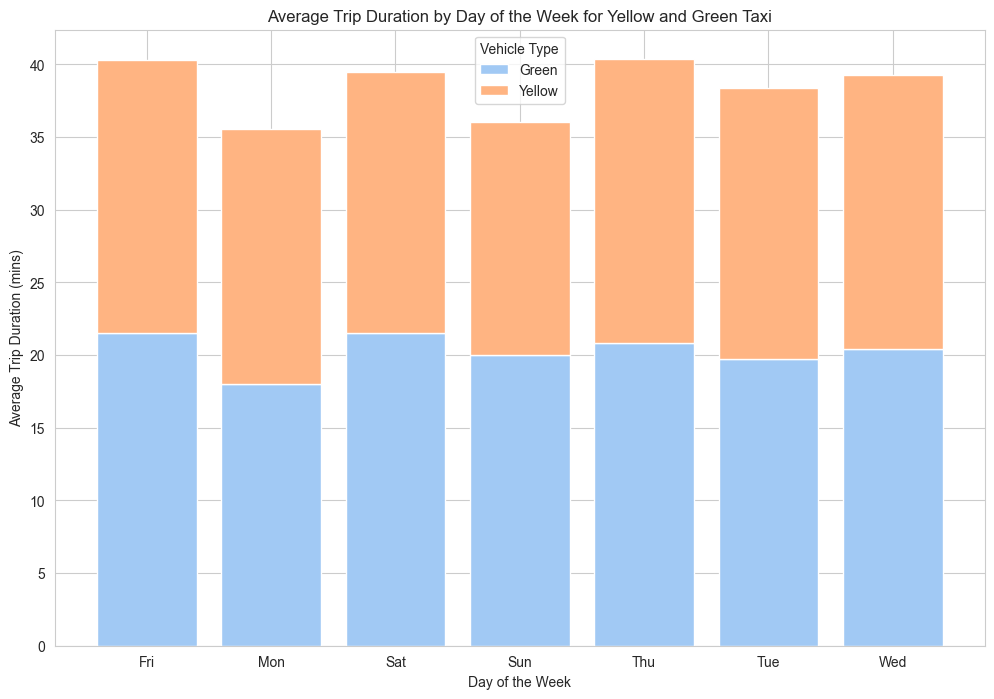

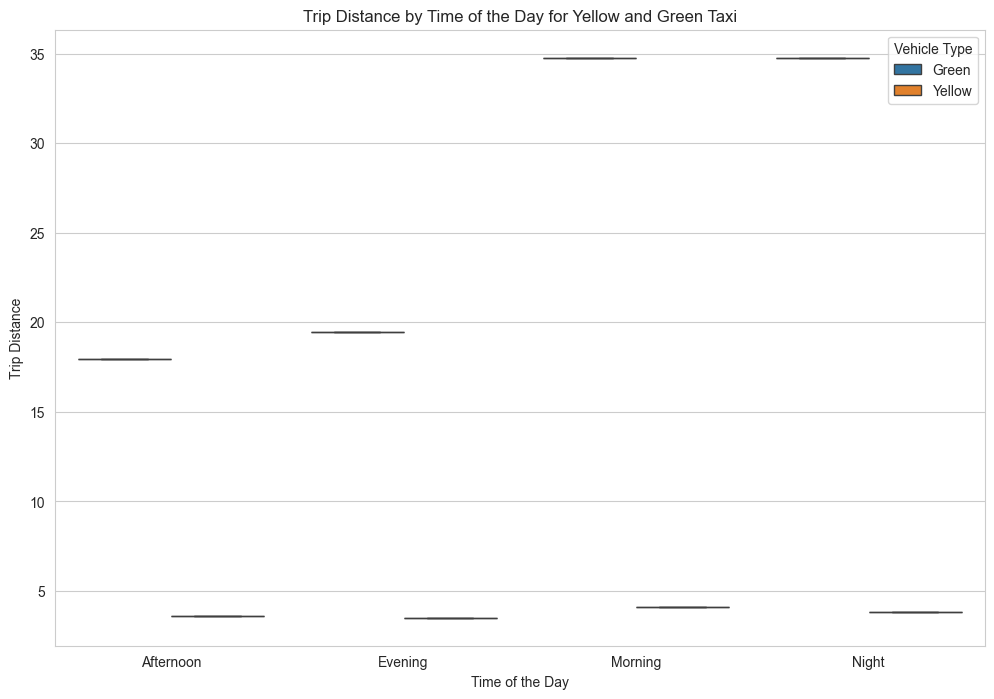

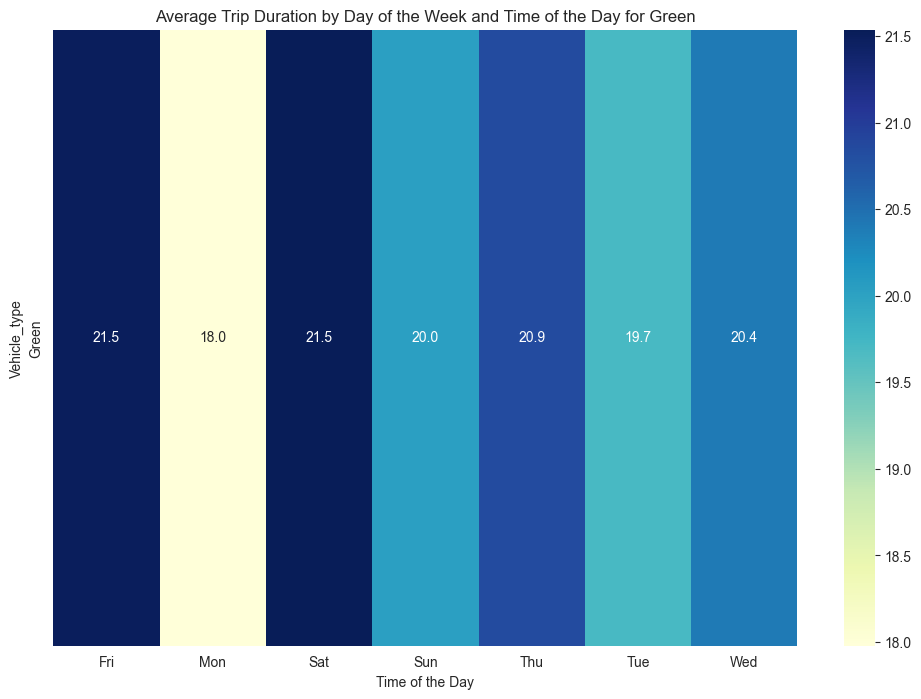

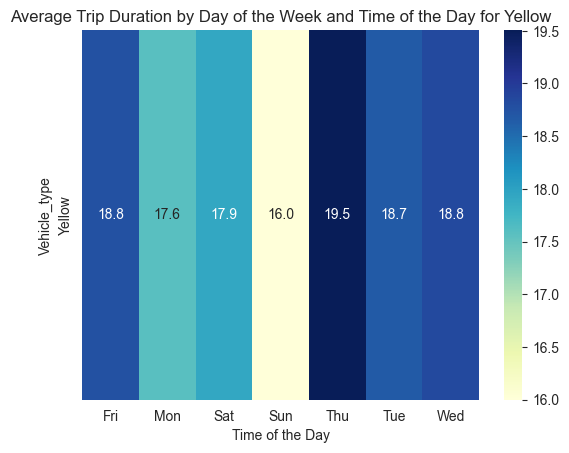

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style to seaborn
sns.set_style("whitegrid")

# Create pastel color palette
palette = sns.color_palette("pastel")

# Bar chart for average trip distance by day of the week for each vehicle type
plt.figure(figsize=(12, 8))
index = 0
for vehicle_type, data in day_of_week_df.groupby(level=0):
    plt.bar(data.index.get_level_values('PU_day_of_week'), data['trip_distance'], label=vehicle_type, color=palette[index])
    index += 1
plt.xlabel('Day of the Week')
plt.ylabel('Average Trip Distance')
plt.title('Average Trip Distance by Day of the Week for Yellow and Green Taxi')
plt.legend(title='Vehicle Type')
plt.savefig('../figures/avg_trip_distance_by_day_of_the_week.png')
plt.show()

# Line chart for total amount by time of the day for each vehicle type
plt.figure(figsize=(12, 8))

index = 0
for vehicle_type, data in time_of_the_day_df.groupby(level=0):
    plt.plot(data.index.get_level_values('Time_of_the_day'), data['total_amount'], label=vehicle_type, marker='o', color=palette[index])
    index += 1
plt.xlabel('Time of the Day')
plt.ylabel('Average Total Charge Amount')
plt.title('Average Total Charge Amount by Time of the Day for Yellow and Green Taxi')
plt.legend(title='Vehicle Type')
plt.savefig('../figures/avg_charge_amount_by_day_of_the_week.png')
plt.show()

# Stacked bar chart for trip duration by day of the week for each vehicle type
plt.figure(figsize=(12, 8))
bottom = None
index = 0
for vehicle_type, data in day_of_week_df.groupby(level=0):
    if bottom is None:
        bottom = plt.bar(data.index.get_level_values('PU_day_of_week'), data['trip_duration_in_mins'], label=vehicle_type,color=palette[index])
        cumulative_heights = data['trip_duration_in_mins'].values
    else:
        plt.bar(data.index.get_level_values('PU_day_of_week'), data['trip_duration_in_mins'], bottom=cumulative_heights, label=vehicle_type, color=palette[index])
        cumulative_heights += data['trip_duration_in_mins'].values
    index += 1
plt.xlabel('Day of the Week')
plt.ylabel('Average Trip Duration (mins)')
plt.title('Average Trip Duration by Day of the Week for Yellow and Green Taxi')
plt.legend(title='Vehicle Type')
plt.savefig('../figures/avg_trip_duration_by_day_of_the_week.png')
plt.show()

# Box plot for trip distance by time of the day for each vehicle type
plt.figure(figsize=(12, 8))
sns.boxplot(x='Time_of_the_day', y='trip_distance', hue='Vehicle_type', data=time_of_the_day_df.reset_index())
plt.xlabel('Time of the Day')
plt.ylabel('Trip Distance')
plt.title('Trip Distance by Time of the Day for Yellow and Green Taxi')
plt.legend(title='Vehicle Type')
plt.savefig('../figures/avg_trip_distance_by_day_of_the_week.png')
plt.show()

# Heatmap for trip duration by day of the week and time of the day for each vehicle type
plt.figure(figsize=(12, 8))
for vehicle_type, data in day_of_week_df.groupby(level=0):
    sns.heatmap(data['trip_duration_in_mins'].unstack(), cmap='YlGnBu', annot=True, fmt=".1f")
    plt.xlabel('Time of the Day')
    # plt.ylabel('Day of the Week')
    plt.title(f'Average Trip Duration by Day of the Week and Time of the Day for {vehicle_type}')
    plt.savefig(f'../figures/avg_trip_duration_by_dow_and_tod_{vehicle_type}.png')
    plt.show()